<a href="https://www.kaggle.com/code/muhammadumair800/vgg16-transferlearning?scriptVersionId=97793498" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#data preprocessing

In [2]:
#setup
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
import gc
import cv2
import math
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#Importing Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

In [3]:
pwd

'/kaggle/working'

In [4]:
mkdir Train

In [5]:
mkdir Test

In [6]:
cd ./Train

/kaggle/working/Train


In [7]:
mkdir covid

In [8]:
mkdir normal

In [9]:
pwd

'/kaggle/working/Train'

In [10]:
cd /kaggle/working/Test

/kaggle/working/Test


In [11]:
mkdir covid

In [12]:
mkdir normal

In [13]:
pwd

'/kaggle/working/Test'

In [14]:
cd ..

/kaggle/working


In [15]:
cp -r ../input/covid19-radiography-database ./

*moving* 3000 images to train>covid

In [16]:
ls covid19-radiography-database/COVID-19_Radiography_Dataset/

 COVID/                       Normal.metadata.xlsx
 COVID.metadata.xlsx          README.md.txt
 Lung_Opacity/               'Viral Pneumonia'/
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal/


In [17]:
ls -Q /kaggle/working/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images | head -3000 | xargs -i mv /kaggle/working/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/{} /kaggle/working/Train/covid/

ls: write error: Broken pipe


In [18]:
ls -Q /kaggle/working/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images | head -3000 | xargs -i mv /kaggle/working/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/{} /kaggle/working/Train/normal/

ls: write error: Broken pipe


In [19]:
ls -Q /kaggle/working/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images | head -600 | xargs -i mv /kaggle/working/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/{} /kaggle/working/Test/covid/

In [20]:
ls -Q /kaggle/working/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images | head -600 | xargs -i mv /kaggle/working/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/{} /kaggle/working/Test/normal/

ls: write error: Broken pipe


In [21]:
height=224
width=224
channels=3
batch_size=32
img_shape=(height, width, channels)
img_size=(height, width)

#Applying data augmentation & on training and validation dataset

In [22]:
Train_Valid_gen=ImageDataGenerator(rescale=(1./255) , rotation_range=180, width_shift_range=0.2, 
                        height_shift_range=0.2, horizontal_flip=True, validation_split=0.1)

In [23]:
train_gen= Train_Valid_gen.flow_from_directory(directory = '/kaggle/working/Train', target_size=img_size, subset='training',
                                               batch_size=batch_size,  class_mode='categorical', seed=58)

Found 5400 images belonging to 2 classes.


In [24]:
Valid_gen= Train_Valid_gen.flow_from_directory(directory = '/kaggle/working/Train', target_size=img_size, subset='validation',
                                               batch_size=batch_size,  class_mode='categorical',seed=12)

Found 600 images belonging to 2 classes.


#data visulization

In [25]:
Valid_gen.class_indices

{'covid': 0, 'normal': 1}

In [26]:
train_gen.class_indices

{'covid': 0, 'normal': 1}

In [28]:
train_images, train_labels = next(train_gen)
val_images, val_labels = next(Valid_gen)

In [29]:
print("Train Images shape " , train_images.shape)
print("Valid Images shape " , train_images.shape)

Train Images shape  (32, 224, 224, 3)
Valid Images shape  (32, 224, 224, 3)


In [30]:
def show_image_samples(gen):
    class_dict=gen.class_indices
    class_names=list( class_dict.keys())       
    images,labels=next(gen) # get a sample batch from the generator   
    plt.figure(figsize=(10, 10))
    length=len(labels)
 
    for i in range(6):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        index=np.argmax(labels[i])
        class_name=class_names[index]
        plt.title(class_name, color='black', fontsize=16)
        plt.axis('off')
    plt.show()
plt. style. use('default')

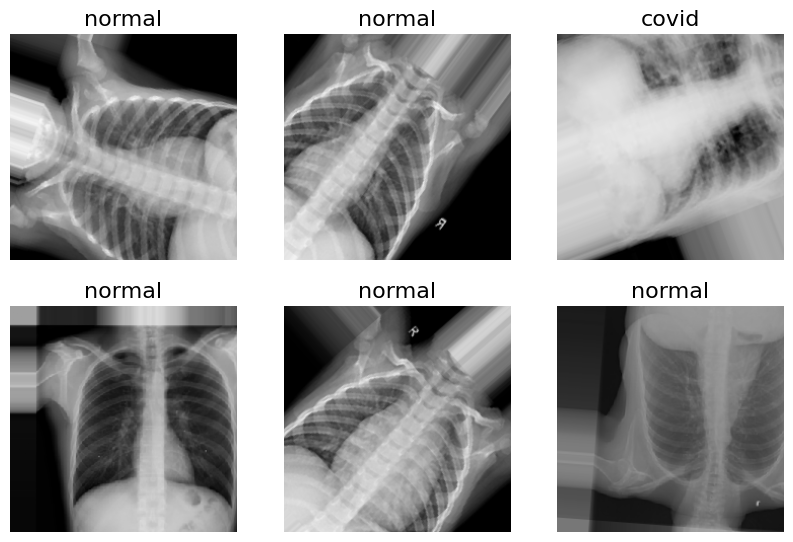

In [31]:
show_image_samples(train_gen)

#Transfer Learning

In [32]:
from tensorflow.keras.layers.experimental import preprocessing
from keras.layers.merge import concatenate
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.layers import MaxPooling2D,BatchNormalization,Dropout,Flatten,Dense,Conv2D,Input,GlobalAveragePooling2D
from tensorflow.keras import layers  
from tensorflow.keras.applications import VGG16

In [33]:
# Input Layer ----> Transfer Learning Algorithm ---> Output Layer 

def build_model():
    # use imagenet - pre-trainined weights for images
    baseModel = VGG16(weights= 'imagenet', include_top = False, input_shape=(img_shape))

    for layer in baseModel.layers[:-3]:
      layer.trainable = False

    headModel = baseModel.output
    headModel = GlobalAveragePooling2D()(headModel)
    headModel = BatchNormalization()(headModel)
    
    headModel = Dense(128, activation="relu")(headModel)
    headModel = BatchNormalization()(headModel)
    headModel = Dense(64, activation="relu")(headModel)
    headModel = BatchNormalization()(headModel)
    
    headModel = Dense(2, activation="softmax")(headModel)
    model = Model(inputs=baseModel.input, outputs=headModel)
    optimizers = RMSprop(learning_rate=0.00001)
    model.compile(loss = 'categorical_crossentropy', optimizer = optimizers, metrics = ['accuracy'])

    return model
model=build_model()
model.summary()

2022-06-08 07:35:46.878991: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 07:35:46.971571: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 07:35:46.972426: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-08 07:35:46.973993: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
______________________________________________________________

In [34]:
from keras.callbacks import ModelCheckpoint
import datetime
import keras


checkpoint_filepath = '/kaggle/working/VGG16.h5'
callbacks = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,   save_weights_only=True,
                           monitor='val_loss',    mode='min',   save_best_only=True,   verbose=3)




cnnModel=model.fit( train_gen, validation_data=Valid_gen, epochs=50,  verbose=1, callbacks=[callbacks])



2022-06-08 07:35:57.001775: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-06-08 07:35:59.755709: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


169/169 [==============================] - 94s 490ms/step - loss: 0.5833 - accuracy: 0.7141 - val_loss: 0.6376 - val_accuracy: 0.5967

Epoch 00001: val_loss improved from inf to 0.63758, saving model to /kaggle/working/VGG16.h5
Epoch 2/50
169/169 [==============================] - 81s 478ms/step - loss: 0.4375 - accuracy: 0.7950 - val_loss: 0.5012 - val_accuracy: 0.7733

Epoch 00002: val_loss improved from 0.63758 to 0.50120, saving model to /kaggle/working/VGG16.h5
Epoch 3/50
169/169 [==============================] - 82s 483ms/step - loss: 0.3820 - accuracy: 0.8307 - val_loss: 0.3374 - val_accuracy: 0.8617

Epoch 00003: val_loss improved from 0.50120 to 0.33738, saving model to /kaggle/working/VGG16.h5
Epoch 4/50
169/169 [==============================] - 81s 477ms/step - loss: 0.3422 - accuracy: 0.8444 - val_loss: 0.2582 - val_accuracy: 0.8867

Epoch 00004: val_loss improved from 0.33738 to 0.25819, saving model to /kaggle/working/VGG16.h5
Epoch 5/50
169/169 [=======================

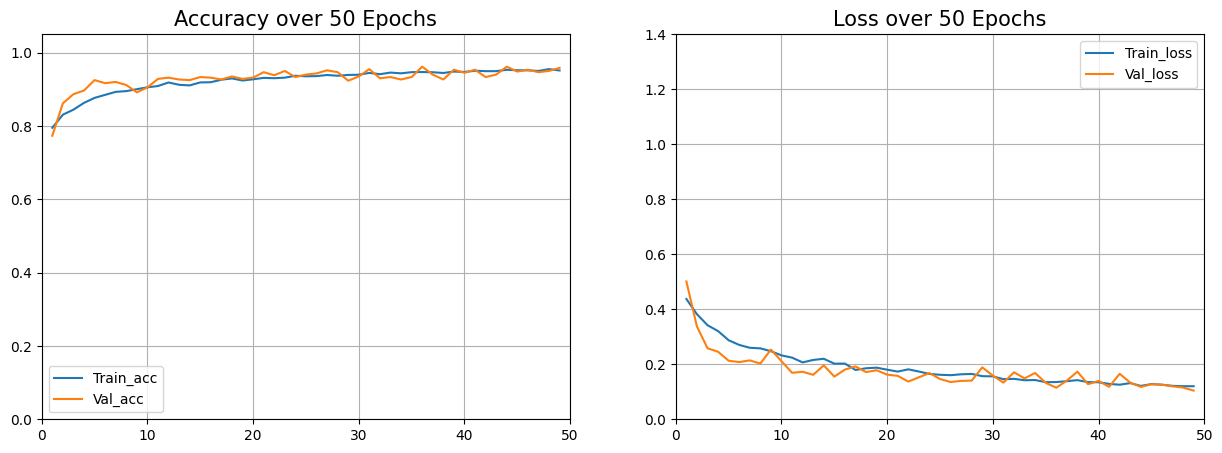

In [35]:
#Plot the accuracy and loss graphs
import matplotlib.pyplot as plt

def plot_acc_loss(result, epochs):
    acc = result.history['accuracy']
    loss = result.history['loss']
    val_acc = result.history['val_accuracy']
    val_loss = result.history['val_loss']
    plt.figure(figsize=(15, 5))
    plt.subplot(121)
    plt.xlim(0,epochs)
    plt.ylim(0, 1.05)
    plt.plot(range(1,epochs), acc[1:], label='Train_acc')
    plt.plot(range(1,epochs), val_acc[1:], label='Val_acc')
    plt.title('Accuracy over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.xlim(0,epochs)
    plt.ylim(0, 1.4)
    plt.plot(range(1,epochs), loss[1:], label='Train_loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Val_loss')
    plt.title('Loss over ' + str(epochs) + ' Epochs', size=15)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(cnnModel, 50)

In [38]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_dir =  '/kaggle/working/Test'
eval_generator = test_datagen.flow_from_directory(test_dir,target_size=img_size,batch_size=1, 
                                                  shuffle=False, seed=42, class_mode="categorical")
eval_generator.reset()
#Evalute the trained model on evaluate generator
eval_generator.reset()  
x = model.evaluate_generator(eval_generator,
                           steps = np.ceil(len(eval_generator)), 
                           use_multiprocessing = False,  verbose = 1,
                           workers=1     )


print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Found 1200 images belonging to 2 classes.
1200/1200 [==============================] - 10s 8ms/step - loss: 0.1145 - accuracy: 0.9625
Test loss: 0.11448977142572403
Test accuracy: 0.9624999761581421


/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


[[563  37]
 [  8 592]]
              precision    recall  f1-score   support

           0       0.99      0.94      0.96       600
           1       0.94      0.99      0.96       600

    accuracy                           0.96      1200
   macro avg       0.96      0.96      0.96      1200
weighted avg       0.96      0.96      0.96      1200



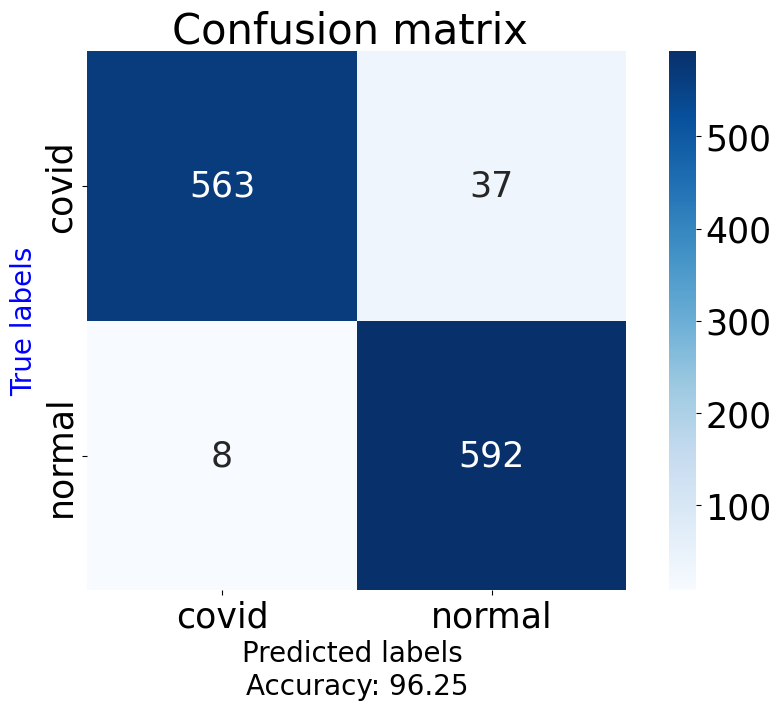

In [39]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix
filenames = eval_generator.filenames
nb_samples = len(filenames)
eval_generator.reset()  
predict = model.predict_generator(eval_generator,steps = np.ceil(len(eval_generator)))
pp=predict
predict=np.argmax(predict, axis=-1)
classes= eval_generator.classes[eval_generator.index_array]
acc=sum(predict==classes)/len(predict)
names=eval_generator.class_indices
cm = confusion_matrix(classes, predict)
print(cm)
print(classification_report(classes,predict))
import seaborn as sns
plt.figure(figsize=(11,7))
x_axis_labels = eval_generator.class_indices
y_axis_labels = eval_generator.class_indices
plt.rcParams.update({'font.size': 25})
sns.heatmap(confusion_matrix(classes, predict),xticklabels=x_axis_labels,
            yticklabels=y_axis_labels,annot= True, fmt='',cmap = 'Blues')
plt.imshow(cm, cmap='binary' )
plt.xlabel('Predicted labels \nAccuracy: {:0.2f}'.format(acc*100),fontsize=20)
plt.ylabel("True labels",fontsize=20,color='b')
plt.title('Confusion matrix ')
plt.show()

covid (0.997)
normal (0.00271)


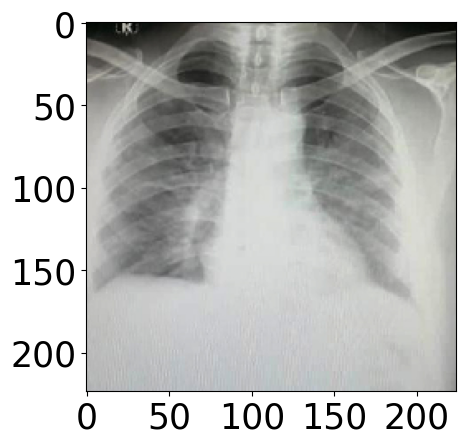

In [40]:
img = image.load_img('../input/covid19-pakistani-patients-xray-image-dataset/LOCALDATA/COVID/1423941754063.jpg',target_size=(img_shape))
img = image.img_to_array(img)
img = img/255.

classes = ['covid','normal']
proba = model.predict(img.reshape(1,224,224,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(2):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)
plt.style.use('classic')

normal (0.998)
covid (0.00229)


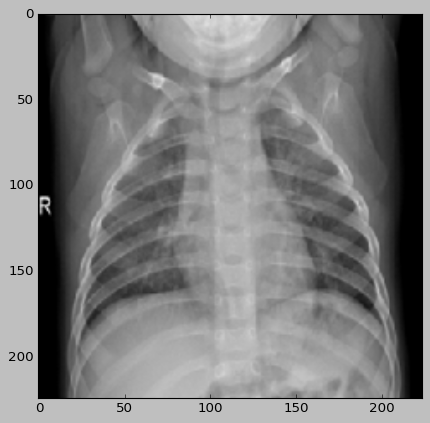

In [44]:
img = image.load_img('../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-1000.png',target_size=(img_shape))
img = image.img_to_array(img)
img = img/255.

classes = ['covid','normal']
proba = model.predict(img.reshape(1,224,224,3))
top_3 = np.argsort(proba[0])[:-4:-1]
for i in range(2):
    print("{}".format(classes[top_3[i]])+" ({:.3})".format(proba[0][top_3[i]]))
plt.imshow(img)
plt.style.use('classic')